<a href="https://colab.research.google.com/github/vic-comm/deep-learning-pytorch/blob/main/cifar_100_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torchvision import datasets
from torchvision import transforms
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
data_path = r'C:\Users\USER\Desktop\STUDY\python\cifar 100'

transform = transforms.Compose([transforms.Resize((32, 32)), transforms.RandomHorizontalFlip(p=0.3),
                                transforms.RandomVerticalFlip(p=0.3), transforms.RandomGrayscale(p=0.2),
                                transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train = datasets.CIFAR100(root= data_path, train=True, download=True, transform=transform)
test = datasets.CIFAR100(root= data_path, train=False, download=True, transform=transform)

100%|██████████| 169001437/169001437 [00:04<00:00, 40600586.30it/s]


Extracting C:\Users\USER\Desktop\STUDY\python\cifar 100/cifar-100-python.tar.gz to C:\Users\USER\Desktop\STUDY\python\cifar 100
Files already downloaded and verified


In [ ]:
n_train = int(len(train) * 0.9)
n_val = len(train) - n_train

train_data, val_data = torch.utils.data.random_split(train, [n_train, n_val])

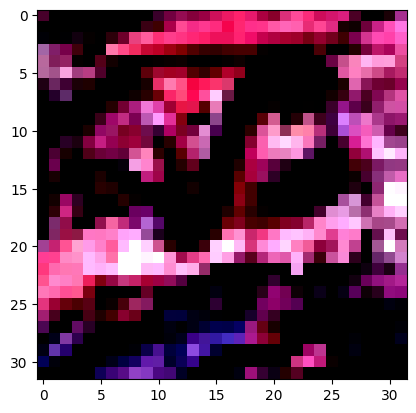

In [ ]:
img, label = train_data[0]
plt.imshow(img.permute(1, 2, 0))

# Different block types for residual network

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, num_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(num_channels, num_channels//2, kernel_size=3, padding=1)
    self.b1 = nn.BatchNorm2d(num_channels//2)
    self.conv2 - nn.Conv2d(num_channels//2, num_channels, kernel_size=3, padding=3)

  def forward(self, x):
    x0 = x
    x = F.relu(x)
    out = F.relu(self.b1(self.conv1(x)))
    out = self.conv2(out)

    return x0+out

In [ ]:
class ResDown(nn.Module):
  def __init__(self, in_channels, out_channels=None):
    super().__init__()

    if not out_channels:
      out_channels= in_channels
    self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
    self.b1 = nn.BatchNorm2d(in_channels//2)
    self.conv2 = nn.Conv2d(in_channels//2, out_channels, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

  def forward(self, x):
    x= F.relu(x)

    x1 = F.relu(self.b1(self.conv1(x)))
    x1 = self.conv2(x1)
    x2 = self.conv3(x)

    return x2+x1

In [ ]:
class SkipBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels, channels//2, kernel_size=3, padding=1)
    self.b1 = nn.BatchNorm2d(channels//2)
    self.conv2 = nn.Conv2d(channels//2, channels//2, kernel_size=3, padding=1)

  def forward(self, x):
    x = F.relu(x)
    x1 = self.conv1(x)
    x2 = F.relu(self.b1(self.conv2(x1)))
    x3 = self.conv2(x)

    return torch.cat((x2, x3), 1)

In [ ]:
# Actual model
class Deep_CNN(nn.Module):
  def __init__(self, channels, output=100, width=64, num_layers=5, layer_type=ResDown):
    super().__init__()
    self.conv1 = nn.Conv2d(channels, width, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(width)
    self.conv2 = nn.Conv2d(width, width//2, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(width//2)
    self.conv3 = nn.Conv2d(width//2, width//2, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(4*4*(width//2), output)

    self.layers = nn.Sequential(*[layer_type(width//2) for _ in range(num_layers)])


  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool(x)

    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool(x)

    x = self.conv3(x)

    x = F.relu(self.layers(x))
    x = self.pool(x)

    x = x.view(x.shape[0], -1)
    x = self.drop(x)
    x = self.linear(x)


    return x

In [ ]:
from torchsummary import summary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Deep_CNN(3).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          18,464
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           9,248
            Conv2d-8             [-1, 16, 8, 8]           4,624
       BatchNorm2d-9             [-1, 16, 8, 8]              32
           Conv2d-10             [-1, 32, 8, 8]           4,640
           Conv2d-11             [-1, 32, 8, 8]           9,248
          ResDown-12             [-1, 32, 8, 8]               0
           Conv2d-13             [-1, 16, 8, 8]           4,624
      BatchNorm2d-14             [-1, 1

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [ ]:
test_loader = DataLoader(test, batch_size=64, shuffle=False)
train_loader = DataLoader(train, batch_size=64, shuffle=True)

In [ ]:
def evaluate(model,test_loader, criterion):
  model.eval()
  test_loss = 0.0
  running_acc = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in test_loader:
      imgs, labels = imgs.to(device).float(), labels.to(device)

      pred = model(imgs)
      loss = criterion(pred, labels)
      test_loss += loss.item()

      _, predicted = torch.max(pred.data, 1)
      total += labels.size(0)
      running_acc += (predicted==labels).sum().item()

    accuracy = (running_acc / total) * 100
    test_loss = test_loss / len(test_loader)
    return test_loss, accuracy

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [ ]:
# Training the model
model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0
    running_acc = 0
    total = 0

    for i, (imgs, labels) in enumerate(train_loader):
      imgs, labels = imgs.to(device), labels.to(device)
      imgs = imgs.float()
      optimizer.zero_grad()

      outputs = model(imgs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()

      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      running_acc += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_acc/total
    epoch_loss = running_loss/(i + 1)

    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 2.5882, Accuracy: 32.87%, Test Loss: 2.8913, Test Accuracy: 27.80%
Epoch [2/100], Loss: 2.5256, Accuracy: 34.02%, Test Loss: 3.0437, Test Accuracy: 24.90%
Epoch [3/100], Loss: 2.4995, Accuracy: 34.84%, Test Loss: 3.3797, Test Accuracy: 22.22%
Epoch [4/100], Loss: 2.4658, Accuracy: 35.63%, Test Loss: 3.3944, Test Accuracy: 21.61%
Epoch [5/100], Loss: 2.4429, Accuracy: 36.00%, Test Loss: 3.5404, Test Accuracy: 19.37%
Epoch [6/100], Loss: 2.4047, Accuracy: 36.98%, Test Loss: 3.3925, Test Accuracy: 22.82%
Epoch [7/100], Loss: 2.3970, Accuracy: 37.06%, Test Loss: 3.2737, Test Accuracy: 24.78%
Epoch [8/100], Loss: 2.3692, Accuracy: 37.38%, Test Loss: 2.9592, Test Accuracy: 27.59%
Epoch [9/100], Loss: 2.3557, Accuracy: 38.02%, Test Loss: 4.2638, Test Accuracy: 16.72%
Epoch [10/100], Loss: 2.3348, Accuracy: 38.24%, Test Loss: 3.3048, Test Accuracy: 23.33%
Epoch [11/100], Loss: 2.3136, Accuracy: 39.07%, Test Loss: 2.5744, Test Accuracy: 33.90%
Epoch [12/100], Loss: 2.3014, 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [ ]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [ ]:
# Saving the model
data_path = r'C:\Users\USER\Desktop\STUDY\python\cifar 100'
torch.save(model.state_dict(), data_path + 'cifar 100.pt')
loaded_model = Deep_CNN()
loaded_model.load_state_dict(torch.load(data_path + 'cifar 100.pt'))
